In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.distributed as dist


In [2]:
from nets.SegRank import SegRank
from data import PlacePulseDataset, AdaptTransform
from train_scripts.SegRank import train
import seg_transforms

In [3]:
## Constants
PLACE_PULSE_PATH ='votes'
IMAGES_PATH= 'pp_cropped/'
MODEL_PATH = 'models/segrank_resnet_wealthy_images_model_35.pth'
IMG_MEAN = np.array((104.00698793,116.66876762,122.67891434), dtype=np.float32)
ATTRIBUTE='wealthy'
BATCH_SIZE = 1

## Setup Network

In [4]:
transformers = transforms.Compose([
        AdaptTransform(seg_transforms.ToArray()),
        AdaptTransform(seg_transforms.SubstractMean(IMG_MEAN)),
        AdaptTransform(seg_transforms.Resize((244,244))),
        AdaptTransform(seg_transforms.ToTorchDims())
        ])

dataset=PlacePulseDataset(
    f'{PLACE_PULSE_PATH}/{ATTRIBUTE}/val.csv',
    IMAGES_PATH,
    transform=transformers,
    return_images=True
    )

loader = DataLoader(dataset, batch_size=1,
                            shuffle=True, num_workers=1, drop_last=True)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dist.init_process_group('gloo', init_method='file:///tmp/tmpfile', rank=0, world_size=1)

In [6]:
net = SegRank(image_size=(244,244))
net.load_state_dict(torch.load(MODEL_PATH, map_location=device))
print('loaded')

loaded


## Forward Pass

In [213]:
batch = next(iter(loader))
input_left, input_right, label, left_original = batch['left_image'], batch['right_image'], batch['winner'], batch['left_image_original']
label

tensor([-1])

In [214]:
with torch.no_grad():
    forward_dict = net(input_left,input_right)
    output_rank_left, output_rank_right =  forward_dict['left']['output'], forward_dict['right']['output']
output_rank_left, output_rank_right

(tensor([[-0.6399766207]]), tensor([[0.2606278956]]))

## Image visualization

In [208]:
from PIL import Image as PILImage
from torch import nn
import cv2

def segmentation_to_image(segmentation, palette, output_size=(244, 244)):
    interp = nn.Upsample(size=output_size, mode='bilinear', align_corners=True)
    segmentation = interp(segmentation.unsqueeze(0)).cpu().numpy().transpose(0,2,3,1)
    seg_pred = np.asarray(np.argmax(segmentation, axis=3), dtype=np.uint8)
    output_im = PILImage.fromarray(seg_pred[0])
    output_im.putpalette(palette)
    return output_im

def attention_to_images(image,attention_map,output_size=(244,244)):
    cvImage = cv2.cvtColor(image.cpu().numpy(), cv2.COLOR_RGB2BGR)
    cvImage = cv2.cvtColor(cvImage, cv2.COLOR_BGR2GRAY)
    cvImage = cv2.cvtColor(cvImage, cv2.COLOR_GRAY2BGR) #we neeed a 3 dimensional gray image
    cvImage = cv2.resize(cvImage, output_size)
    attention_map = attention_map[:,:,0:960]
    interp = nn.Upsample(size=output_size, mode='bilinear', align_corners=True)
    attention_map = attention_map.mean(dim=2, keepdim=True)
    attention_size = attention_map.size()
    dim = int(attention_size[1]**(0.5))
    attention_map = attention_map.view((attention_size[0],1,dim,dim))
    attention_map = interp(attention_map).squeeze(1).cpu().detach().numpy()
    images = []
    for single_map in attention_map:
        heatmap_img = None
        heatmap_img = cv2.normalize(single_map, heatmap_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        heatmap_img = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_JET)
        result = cv2.addWeighted(heatmap_img, 0.5, cvImage, 0.5, 0)
        images.append(result)
    return images


def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """

    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette

def image_log(segmentation,original,attention_map,palette):
    seg_img = segmentation_to_image(segmentation,palette)
    attentions = attention_to_images(original, attention_map)
    return seg_img, attentions

def show_layout(images):
    fig = plt.figure(figsize=(50, 50))
    for i in range(len(images)):
        sub = fig.add_subplot(6, 4, i + 1)
        sub.imshow(images[i], interpolation='nearest')

In [209]:
%matplotlib inline
torch.set_printoptions(precision=10)

segmentation = forward_dict['left']['segmentation'][0]
original = left_original[0]
attention_map = forward_dict['left']['attention'][0][0]
seg_img, attentions = image_log(segmentation,original,attention_map,get_palette(19))

In [192]:
attention_map = attention_map[0:1,:,957:961]

In [193]:
attention_size = attention_map.size()
dim = int(attention_size[1]**(0.5))

In [194]:
attention_size

torch.Size([1, 961, 4])

In [195]:
attention_mean = attention_map.mean(dim=2,keepdim=True)
attention_mean.size()

torch.Size([1, 961, 1])

In [196]:
print(attention_mean[0][960][0])
values = [attention_map[0][960][i] for i in range(4)]
print(sum(values)/4)

tensor(0.0008159299)
tensor(0.0008159299)


In [197]:
attention_mean = attention_mean.view((attention_size[0],1,dim,dim))[0]
attention_mean.size()

torch.Size([1, 31, 31])

In [198]:
attention_map = attention_map.view((attention_size[0],dim,dim,4)).permute([0,3,1,2])[0] #BUG : ESTE PASO NO MANTIENE LAS POSICIONES
attention_map.size()

torch.Size([4, 31, 31])

In [199]:
print(attention_mean[0][30][30])
values = [attention_map[i][30][30] for i in range(4)]
print(sum(values)/4)

tensor(0.0008159299)
tensor(0.0008159299)


In [200]:
final = np.vstack([attention_map.numpy(),attention_mean.numpy()])
final.shape

(5, 31, 31)

In [201]:
images=[]
heatmap_img = None
heatmap_img = cv2.normalize(final, heatmap_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

In [202]:
images=[]
for img in heatmap_img:
    img = cv2.applyColorMap(img, cv2.COLORMAP_HSV)
    #result = cv2.addWeighted(heatmap_img, 0.5, cvImage, 0.5, 0)
    images.append(img)

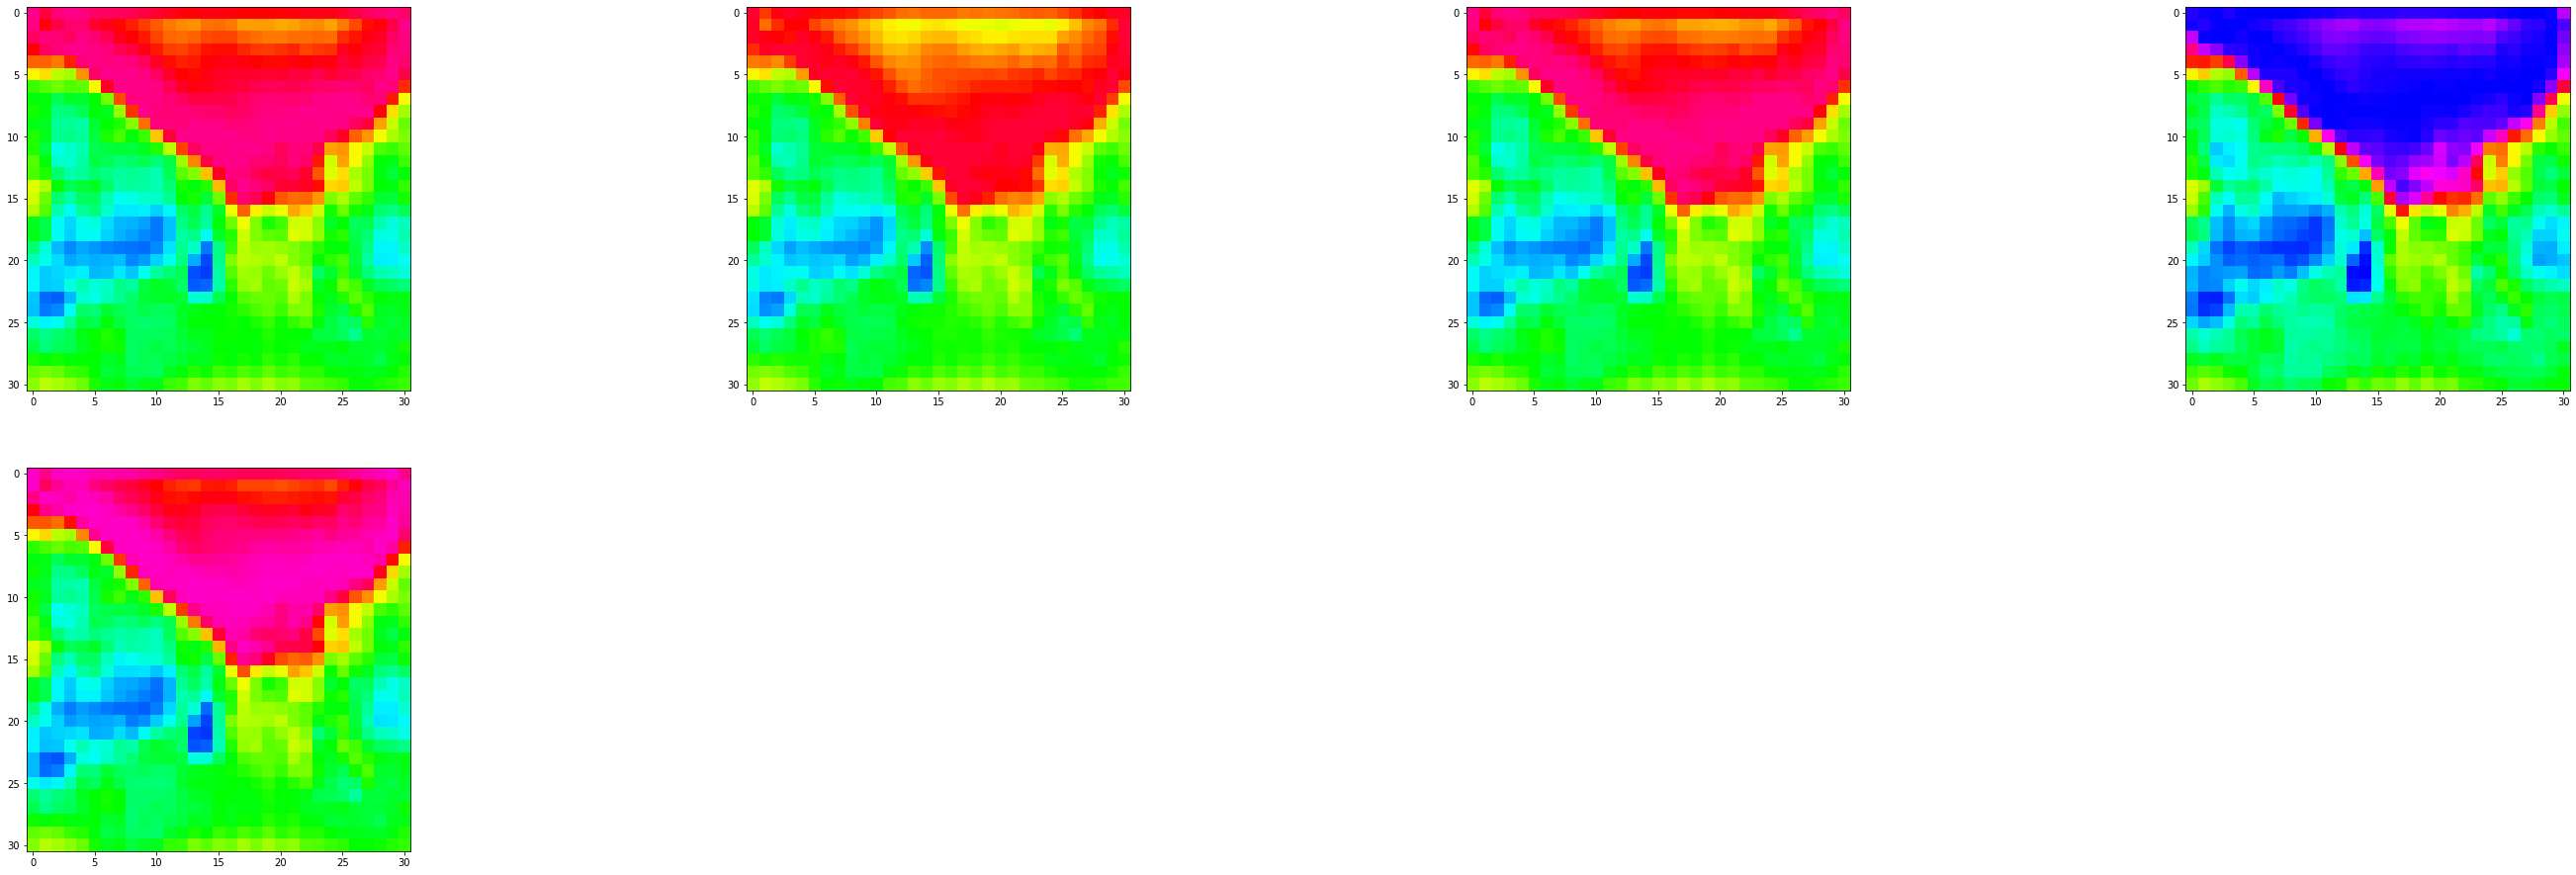

In [203]:
show_layout(images)

In [108]:
interp = nn.Upsample(size=(244,244), mode='bilinear', align_corners=True)

In [116]:
final_mean = interp(attention_mean.unsqueeze(0)).squeeze(0).numpy()

In [117]:
images=[]
heatmap_img = None
heatmap_img = cv2.normalize(final_mean, heatmap_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
for img in heatmap_img:
    img = cv2.applyColorMap(img, cv2.COLORMAP_HSV)
    #result = cv2.addWeighted(heatmap_img, 0.5, cvImage, 0.5, 0)
    images.append(img)

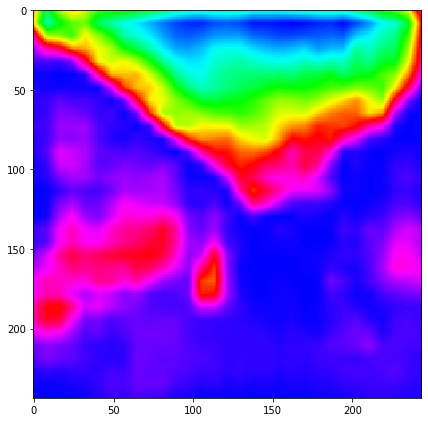

In [118]:
show_layout(images)

In [185]:
attention_map = forward_dict['left']['attention'][0][0]
attention_map = attention_map[:,:,0:960]
attention_size = attention_map.size()
dim = int(attention_size[1]**(0.5))
print(attention_size,dim)
attention_mean = attention_map.mean(dim=2,keepdim=True)
attention_mean = attention_mean.view((attention_size[0],1,dim,dim))
final_mean = interp(attention_mean).squeeze(1).numpy()
images=[]
for img in final_mean:
    heatmap_img = None
    heatmap_img = cv2.normalize(img, heatmap_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    img = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_HSV)
    #result = cv2.addWeighted(heatmap_img, 0.5, cvImage, 0.5, 0)
    images.append(img)

torch.Size([19, 961, 960]) 31


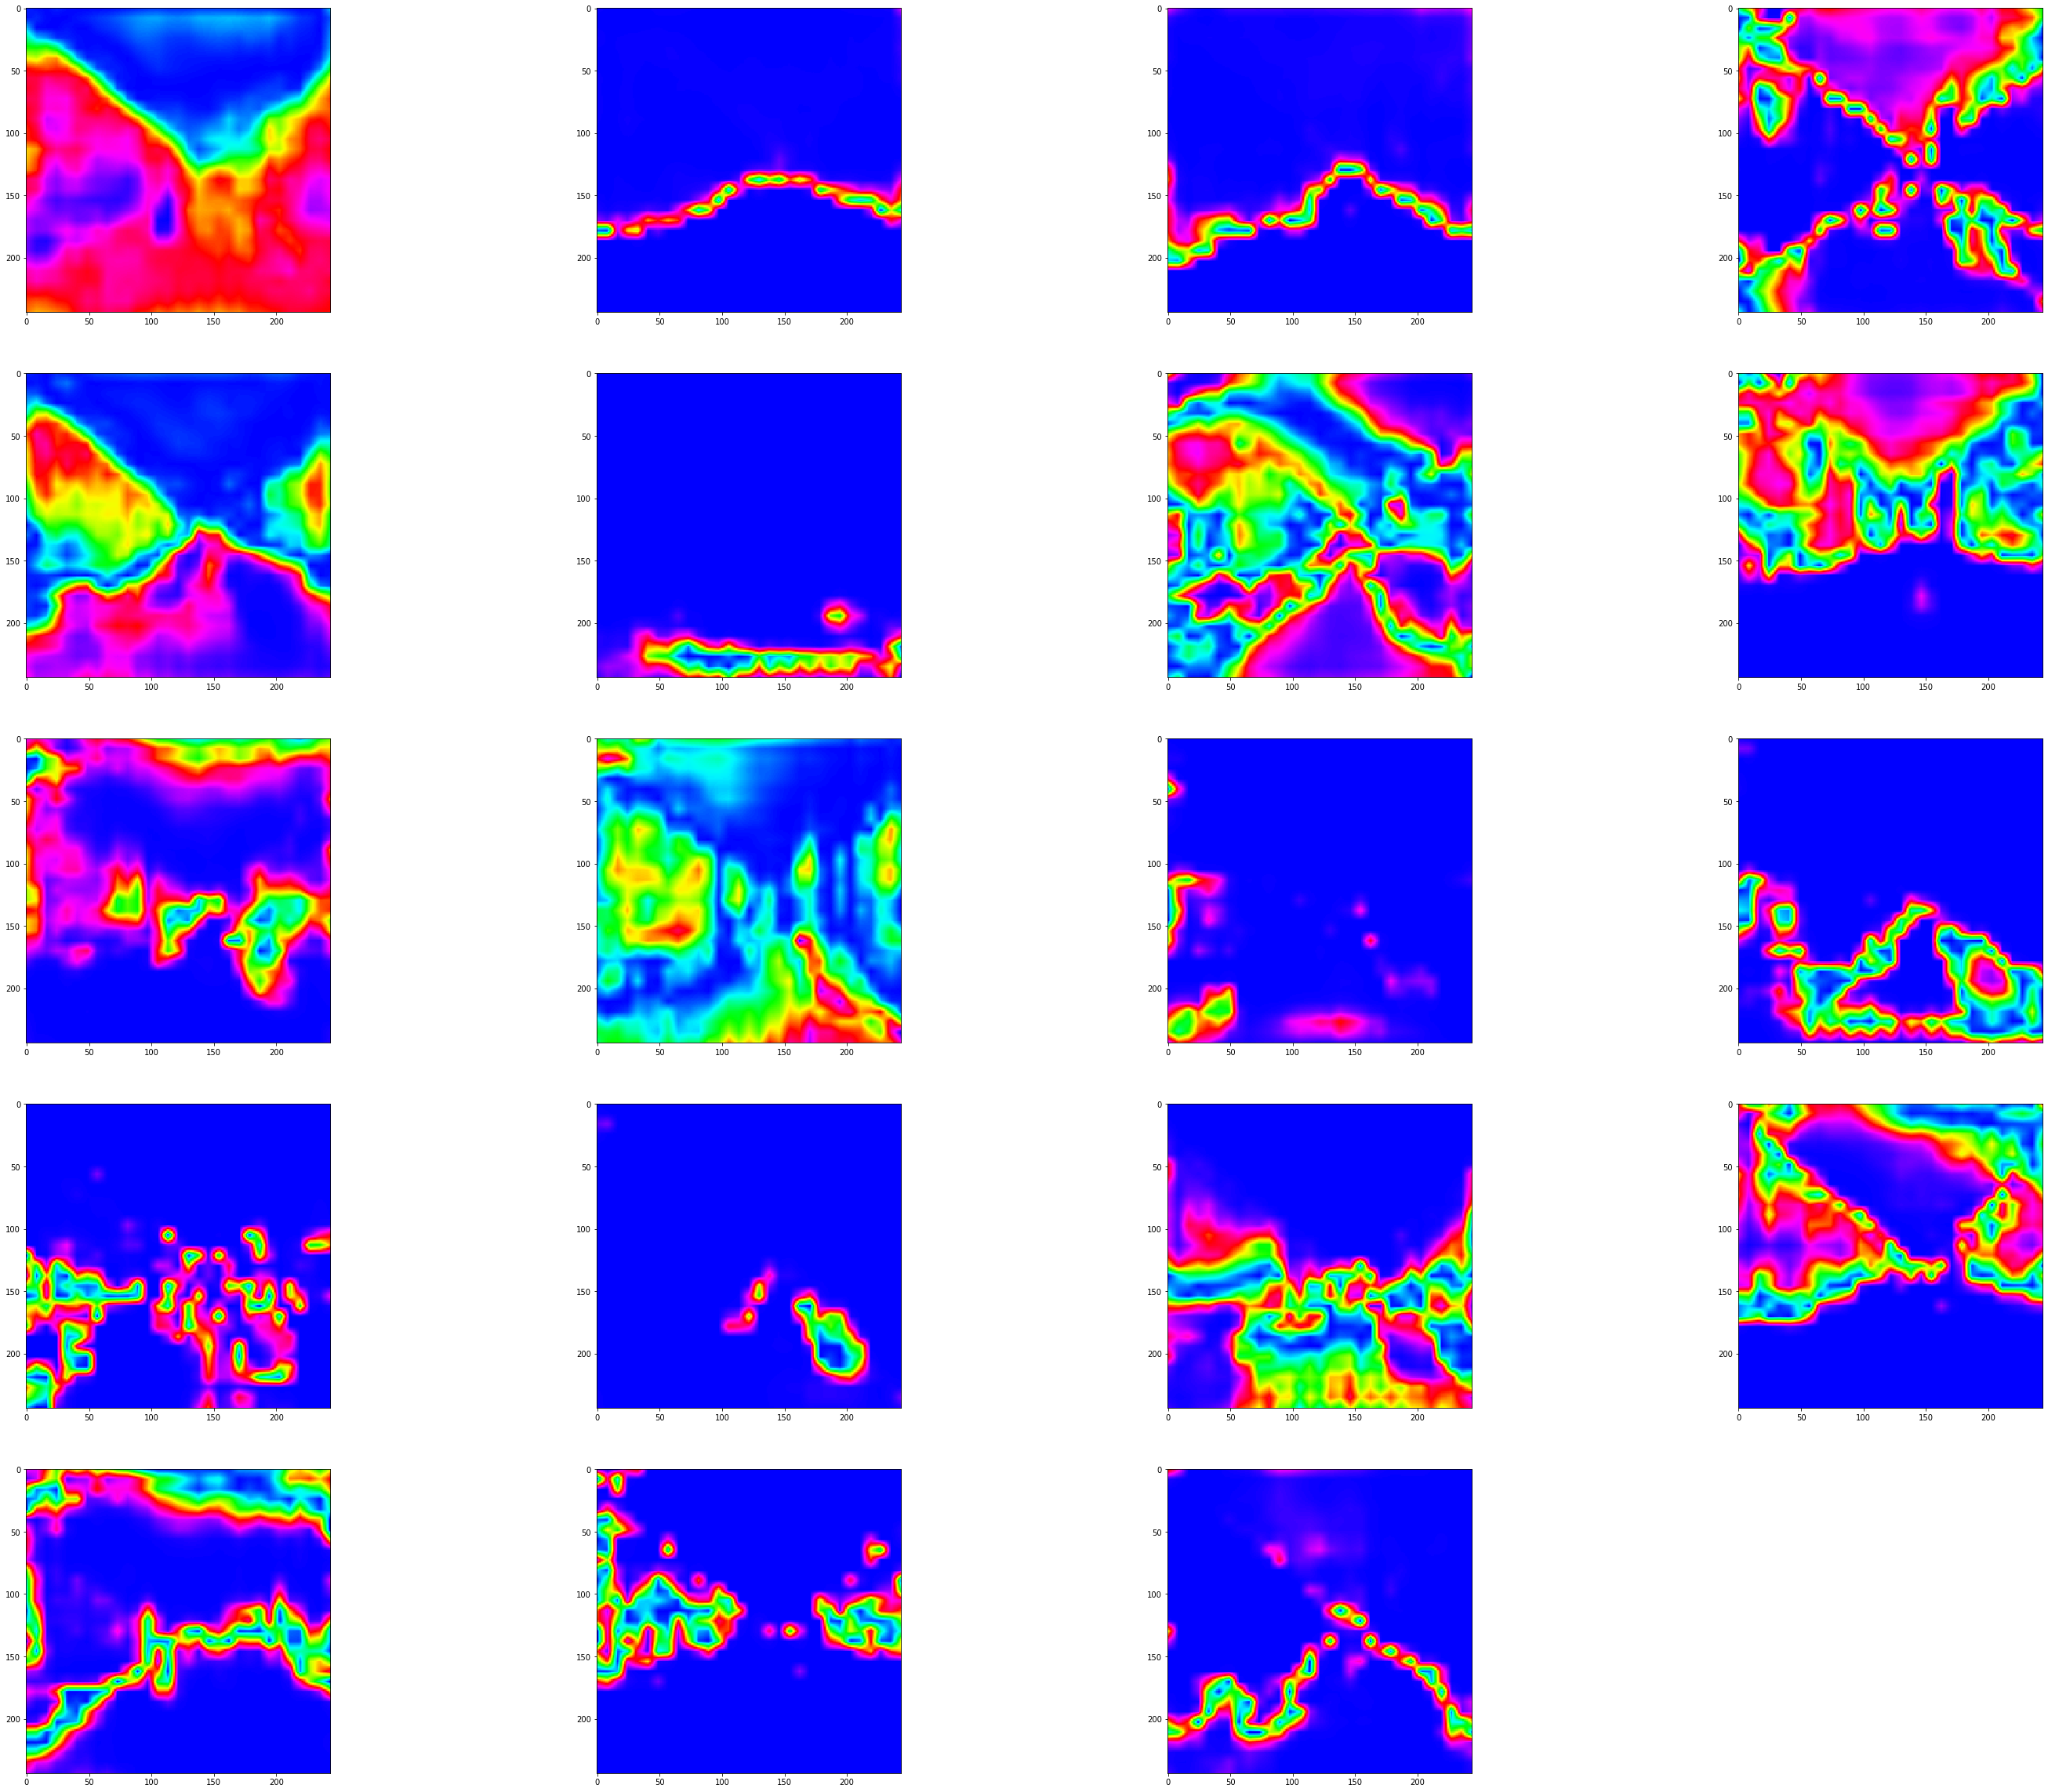

In [183]:
show_layout(images)

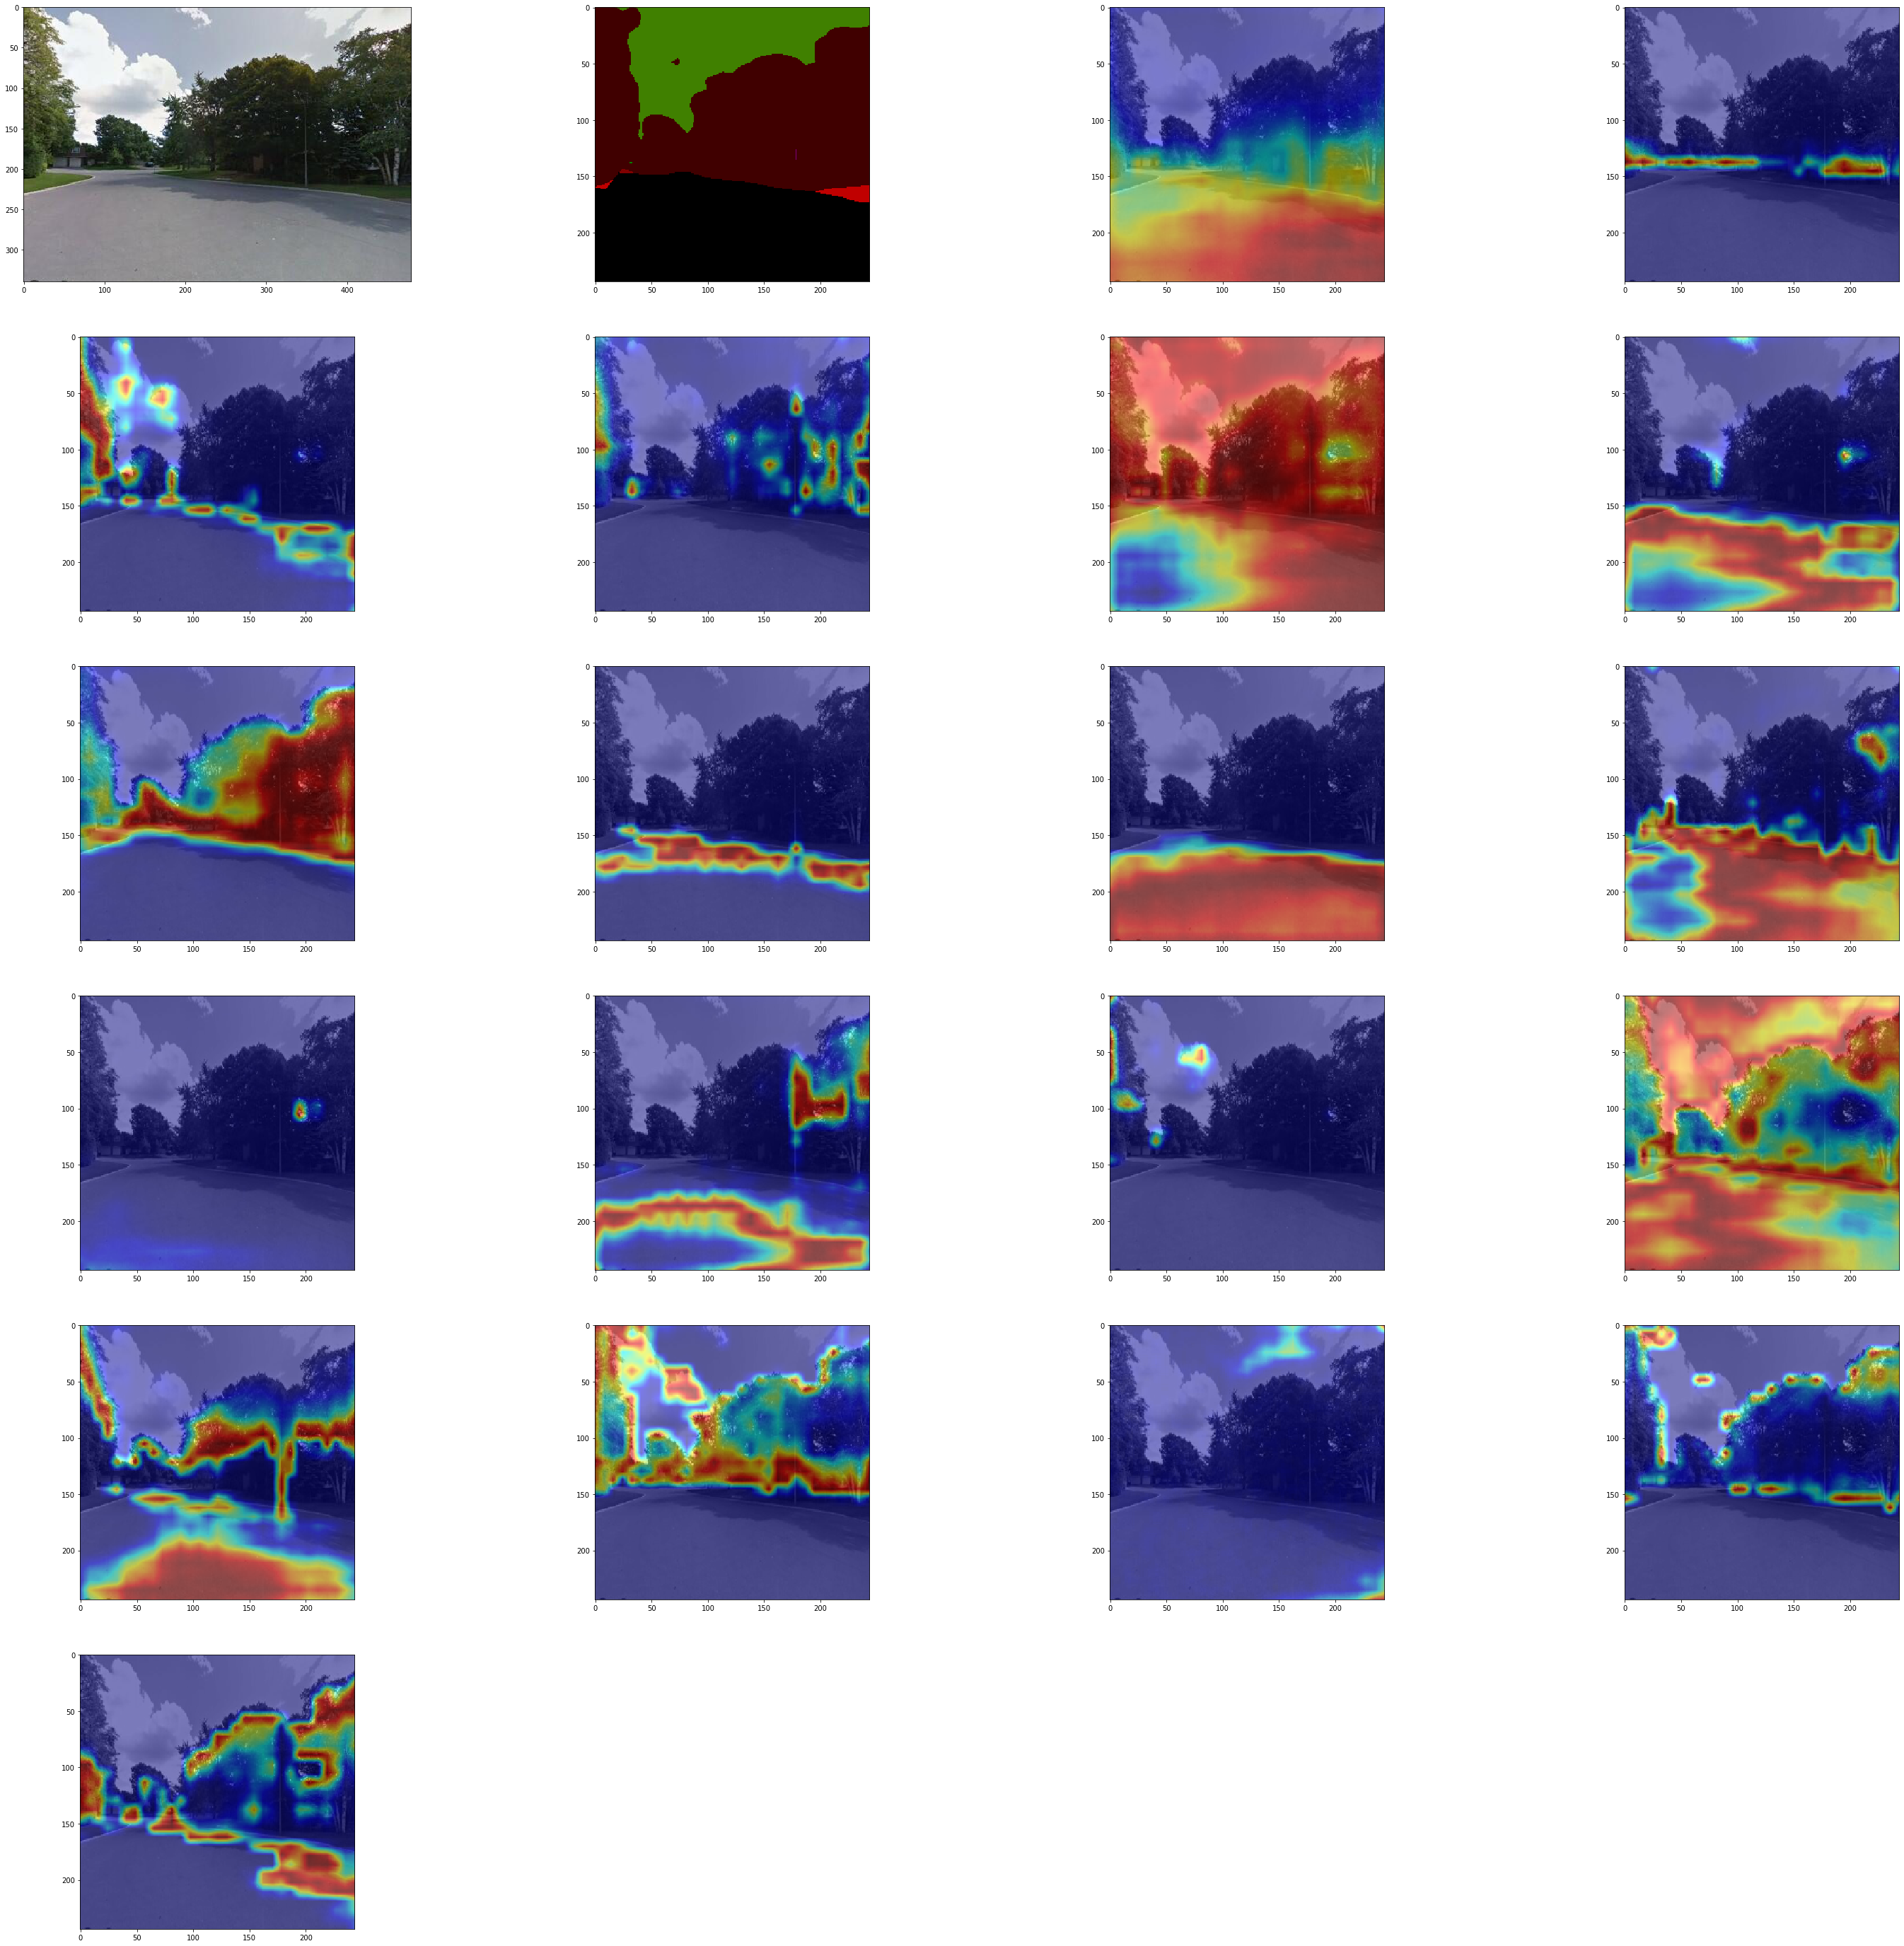

In [216]:
batch = next(iter(loader))
input_left, input_right, label, left_original = batch['left_image'], batch['right_image'], batch['winner'], batch['left_image_original']
with torch.no_grad():
    forward_dict = net(input_left,input_right)
    output_rank_left, output_rank_right =  forward_dict['left']['output'], forward_dict['right']['output']
segmentation = forward_dict['left']['segmentation'][0]
original = left_original[0]
attention_map = forward_dict['left']['attention'][0][0]
seg_img, attentions = image_log(segmentation,original,attention_map,get_palette(19))
show_layout([original,seg_img] + attentions)